# NBA ROLE PLAYER OFFENSIVE/DEFENSIVE ROLES KNN ANALYSIS 

## IMPORTING DATA & LIBRARIES

In [1]:
# nba data
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import leaguedashplayerptshot

# packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn

# scikit
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import decomposition

In [2]:
# Pull data for the top 1000 scorers by PTS column - basically just gets players that actually play
top_1000 = leagueleaders.LeagueLeaders(
    season='2022-23',
    season_type_all_star='Regular Season',
    stat_category_abbreviation='PTS'
).get_data_frames()[0][:1000]
top_1000.head()

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,74,2732,727,1559,0.466,...,649,342,78,51,213,160,2225,2209,1.61,0.37
1,203954,2,Joel Embiid,1610612755,PHI,66,2284,728,1328,0.548,...,670,274,66,112,226,205,2183,2369,1.21,0.29
2,1629029,3,Luka Doncic,1610612742,DAL,66,2391,719,1449,0.496,...,569,529,90,33,236,166,2138,2214,2.24,0.38
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,2416,704,1381,0.510,...,329,371,112,65,192,192,2135,2073,1.93,0.58
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,2024,707,1278,0.553,...,742,359,52,51,246,197,1959,2072,1.46,0.21


In [3]:
# pull shot frequency data
shot_frequency = leaguedashplayerptshot.LeagueDashPlayerPtShot(
    season='2022-23',
    season_type_all_star='Regular Season').get_data_frames()[0]
shot_frequency.head()

,PLAYER_ID,PLAYER_NAME,PLAYER_LAST_TEAM_ID,PLAYER_LAST_TEAM_ABBREVIATION,AGE,GP,G,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,1628369,Jayson Tatum,1610612738,BOS,25.0,74,74,1.0,727,1559,0.466,0.543,0.560,487,873,0.558,0.440,240,686,0.350
1,1630162,Anthony Edwards,1610612750,MIN,21.0,78,78,1.0,694,1517,0.457,0.526,0.624,485,947,0.512,0.376,209,570,0.367
2,1629029,Luka Doncic,1610612742,DAL,24.0,66,66,1.0,719,1449,0.496,0.560,0.627,534,908,0.588,0.373,185,541,0.342
3,203944,Julius Randle,1610612752,NYK,28.0,77,77,1.0,658,1431,0.460,0.536,0.556,440,795,0.553,0.444,218,636,0.343
4,1628378,Donovan Mitchell,1610612739,CLE,26.0,68,68,1.0,679,1402,0.484,0.572,0.547,434,767,0.566,0.453,245,635,0.386


## EDA

In [4]:
# make col names lowercase
top_1000.columns = map(str.lower, top_1000.columns)

In [5]:
# create per game averages
top_1000[['min', 'fgm',
       'fga', 'fg3m', 'fg3a',  'ftm', 'fta', 
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov']] = top_1000[['min', 'fgm',
       'fga', 'fg3m', 'fg3a',  'ftm', 'fta', 
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov']].div(top_1000.gp, axis=0)
top_1000.head()

,player_id,rank,player,team_id,team,gp,min,fgm,fga,fg_pct,...,reb,ast,stl,blk,tov,pf,pts,eff,ast_tov,stl_tov
0,1628369,1,Jayson Tatum,1610612738,BOS,74,36.918919,9.824324,21.067568,0.466,...,8.770270,4.621622,1.054054,0.689189,2.878378,2.162162,30.067568,29.851351,0.021757,0.005000
1,203954,2,Joel Embiid,1610612755,PHI,66,34.606061,11.030303,20.121212,0.548,...,10.151515,4.151515,1.000000,1.696970,3.424242,3.106061,33.075758,35.893939,0.018333,0.004394
2,1629029,3,Luka Doncic,1610612742,DAL,66,36.227273,10.893939,21.954545,0.496,...,8.621212,8.015152,1.363636,0.500000,3.575758,2.515152,32.393939,33.545455,0.033939,0.005758
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.529412,10.352941,20.308824,0.510,...,4.838235,5.455882,1.647059,0.955882,2.823529,2.823529,31.397059,30.485294,0.028382,0.008529
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.126984,11.222222,20.285714,0.553,...,11.777778,5.698413,0.825397,0.809524,3.904762,3.126984,31.095238,32.888889,0.023175,0.003333


In [6]:
# rename columns
top_1000_avg = top_1000.rename(columns={'min':'mpg', 'fgm':'fgm_pg',
       'fga':'fga_pg', 'fg3m':'fg3m_pg', 'fg3a':'fg3a_pg', 'ftm':'ftm_pg', 'fta':'fta_pg', 
       'oreb':'oreb_pg', 'dreb':'dreb_pg', 'reb':'rpg', 'ast':'apg', 'stl':'spg', 'blk':'bpg', 'tov':'tov_pg', 'pf':'pf_pg', 'pts':'ppg', 'eff':'eff_pg',
       'ast_tov':'ast_tov_pg', 'stl_tov':'stl:tov_pg'})
top_1000_avg.head()

,player_id,rank,player,team_id,team,gp,mpg,fgm_pg,fga_pg,fg_pct,...,rpg,apg,spg,bpg,tov_pg,pf_pg,ppg,eff_pg,ast_tov_pg,stl:tov_pg
0,1628369,1,Jayson Tatum,1610612738,BOS,74,36.918919,9.824324,21.067568,0.466,...,8.770270,4.621622,1.054054,0.689189,2.878378,2.162162,30.067568,29.851351,0.021757,0.005000
1,203954,2,Joel Embiid,1610612755,PHI,66,34.606061,11.030303,20.121212,0.548,...,10.151515,4.151515,1.000000,1.696970,3.424242,3.106061,33.075758,35.893939,0.018333,0.004394
2,1629029,3,Luka Doncic,1610612742,DAL,66,36.227273,10.893939,21.954545,0.496,...,8.621212,8.015152,1.363636,0.500000,3.575758,2.515152,32.393939,33.545455,0.033939,0.005758
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.529412,10.352941,20.308824,0.510,...,4.838235,5.455882,1.647059,0.955882,2.823529,2.823529,31.397059,30.485294,0.028382,0.008529
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.126984,11.222222,20.285714,0.553,...,11.777778,5.698413,0.825397,0.809524,3.904762,3.126984,31.095238,32.888889,0.023175,0.003333


In [7]:
# rename column in shot frqncy df for merge
shot_frequency = shot_frequency.rename(columns = {'PLAYER_NAME': 'player'})

In [8]:
# join dataframes
player_df = pd.merge(top_1000_avg,shot_frequency,on='player',how='outer',indicator=True)
player_df.head()

,player_id,rank,player,team_id,team,gp,mpg,fgm_pg,fga_pg,fg_pct,...,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT,_merge
0,1628369,1,Jayson Tatum,1610612738,BOS,74,36.918919,9.824324,21.067568,0.466,...,0.543,0.560,487.0,873.0,0.558,0.440,240.0,686.0,0.350,both
1,203954,2,Joel Embiid,1610612755,PHI,66,34.606061,11.030303,20.121212,0.548,...,0.573,0.849,662.0,1128.0,0.587,0.151,66.0,200.0,0.330,both
2,1629029,3,Luka Doncic,1610612742,DAL,66,36.227273,10.893939,21.954545,0.496,...,0.560,0.627,534.0,908.0,0.588,0.373,185.0,541.0,0.342,both
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.529412,10.352941,20.308824,0.510,...,0.531,0.878,646.0,1213.0,0.533,0.122,58.0,168.0,0.345,both
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.126984,11.222222,20.285714,0.553,...,0.571,0.866,660.0,1108.0,0.596,0.134,47.0,171.0,0.275,both


In [9]:
# filter rows that are only in top_1000_df & display
unmatched_rows = player_df[player_df['_merge'] != 'both']

# Display the unmatched rows
print(unmatched_rows)

     player_id  rank              player     team_id team  gp  mpg  fgm_pg  \
534    1631214   535    Alondes Williams  1610612751  BKN   1  5.0     0.0   
537    1630701   535  Michael Foster Jr.  1610612755  PHI   1  1.0     0.0   

     fga_pg  fg_pct  ...  EFG_PCT  FG2A_FREQUENCY  FG2M  FG2A  FG2_PCT  \
534     0.0     0.0  ...      NaN             NaN   NaN   NaN      NaN   
537     0.0     0.0  ...      NaN             NaN   NaN   NaN      NaN   

     FG3A_FREQUENCY  FG3M  FG3A  FG3_PCT     _merge  
534             NaN   NaN   NaN      NaN  left_only  
537             NaN   NaN   NaN      NaN  left_only  

[2 rows x 48 columns]


In [10]:
# remove rows that aren't matching
player_df = player_df.drop(player_df[(player_df['player'] == 'Alondes Williams') |(player_df['player'] == 'Michael Foster Jr.')].index)

In [11]:
# remove _merge column
player_df = player_df.drop(columns=['_merge'])

In [12]:
player_df.columns

Index(['player_id', 'rank', 'player', 'team_id', 'team', 'gp', 'mpg', 'fgm_pg',
       'fga_pg', 'fg_pct', 'fg3m_pg', 'fg3a_pg', 'fg3_pct', 'ftm_pg', 'fta_pg',
       'ft_pct', 'oreb_pg', 'dreb_pg', 'rpg', 'apg', 'spg', 'bpg', 'tov_pg',
       'pf_pg', 'ppg', 'eff_pg', 'ast_tov_pg', 'stl:tov_pg', 'PLAYER_ID',
       'PLAYER_LAST_TEAM_ID', 'PLAYER_LAST_TEAM_ABBREVIATION', 'AGE', 'GP',
       'G', 'FGA_FREQUENCY', 'FGM', 'FGA', 'FG_PCT', 'EFG_PCT',
       'FG2A_FREQUENCY', 'FG2M', 'FG2A', 'FG2_PCT', 'FG3A_FREQUENCY', 'FG3M',
       'FG3A', 'FG3_PCT'],
      dtype='object')

In [13]:
# remove irrelevant cols - did it this way bc sometimes will remove duplicate columns
player_df = player_df.drop(columns = ['player_id','rank','team_id', 'PLAYER_ID', 'PLAYER_LAST_TEAM_ID',
       'PLAYER_LAST_TEAM_ABBREVIATION', 'AGE', 'GP', 'G','FG2M', 'FG2A','FG3M', 'FG3A','fg_pct','fg3_pct','ft_pct'])

In [14]:
# make cols lower case
player_df.columns = map(str.lower, player_df.columns)
player_df.columns

Index(['player', 'team', 'gp', 'mpg', 'fgm_pg', 'fga_pg', 'fg3m_pg', 'fg3a_pg',
       'ftm_pg', 'fta_pg', 'oreb_pg', 'dreb_pg', 'rpg', 'apg', 'spg', 'bpg',
       'tov_pg', 'pf_pg', 'ppg', 'eff_pg', 'ast_tov_pg', 'stl:tov_pg',
       'fga_frequency', 'fgm', 'fga', 'fg_pct', 'efg_pct', 'fg2a_frequency',
       'fg2_pct', 'fg3a_frequency', 'fg3_pct'],
      dtype='object')

In [15]:
# filter for 'role players' -> define role players as players playing 10<mpg<34 & avging <23 ppg (as per 6moty), must also play more than 35 games to be a viable rotational piece
role_players_2022 = player_df[(player_df['mpg'] < 30) & (player_df['mpg'] > 10) & (player_df['ppg'] < 23) & (player_df['gp'] > 35)]
role_players_2022.head()

,player,team,gp,mpg,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,...,stl:tov_pg,fga_frequency,fgm,fga,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
18,Jordan Poole,GSW,82,29.975610,6.707317,15.585366,2.609756,7.768293,4.402439,5.060976,...,0.003049,1.0,542.0,1262.0,0.429,0.513,0.500,0.523,0.500,0.336
49,Bennedict Mathurin,IND,78,28.487179,5.294872,12.192308,1.282051,3.974359,4.820513,5.820513,...,0.004103,1.0,413.0,951.0,0.434,0.487,0.674,0.488,0.326,0.323
64,Immanuel Quickley,NYK,81,28.938272,5.172840,11.555556,2.074074,5.604938,2.506173,3.061728,...,0.009877,1.0,419.0,936.0,0.448,0.537,0.515,0.521,0.485,0.370
68,Jaren Jackson Jr.,MEM,63,28.380952,6.603175,13.047619,1.587302,4.476190,3.825397,4.857143,...,0.009683,1.0,416.0,822.0,0.506,0.567,0.657,0.585,0.343,0.355
71,Russell Westbrook,LAC,73,29.123288,5.917808,13.575342,1.219178,3.917808,2.821918,4.301370,...,0.004110,1.0,430.0,987.0,0.436,0.481,0.710,0.486,0.290,0.311


In [16]:
# reset index and drop gp column
role_players_2022 = role_players_2022.sort_values(by='player').drop(['gp'],axis=1).reset_index(drop=True)
role_players_2022.head()

,player,team,mpg,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,...,stl:tov_pg,fga_frequency,fgm,fga,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
0,AJ Griffin,ATL,19.458333,3.444444,7.402778,1.402778,3.597222,0.583333,0.652778,0.513889,...,0.013889,1.0,248.0,533.0,0.465,0.560,0.514,0.536,0.486,0.390
1,Aaron Holiday,ATL,13.412698,1.460317,3.492063,0.571429,1.396825,0.428571,0.507937,0.396825,...,0.016349,1.0,92.0,220.0,0.418,0.500,0.600,0.424,0.400,0.409
2,Aaron Nesmith,IND,24.876712,3.452055,8.082192,1.575342,4.301370,1.630137,1.945205,0.849315,...,0.010000,1.0,252.0,590.0,0.427,0.525,0.468,0.496,0.532,0.366
3,Aaron Wiggins,OKC,18.528571,2.657143,5.185714,0.685714,1.742857,0.842857,1.014286,0.971429,...,0.010143,1.0,186.0,363.0,0.512,0.579,0.664,0.573,0.336,0.393
4,Admiral Schofield,ORL,12.189189,1.486486,3.297297,0.648649,2.000000,0.567568,0.621622,0.621622,...,0.013514,1.0,55.0,122.0,0.451,0.549,0.393,0.646,0.607,0.324


In [17]:
# see if there are any NAs
pd.DataFrame(role_players_2022.isna().sum()).sort_values(by = 0,ascending = False).head(10)

,0
fg3_pct,5
team,0
fg3a_frequency,0
fg2_pct,0
fg2a_frequency,0
efg_pct,0
fg_pct,0
fga,0
fgm,0
fga_frequency,0


In [18]:
# NAs for 3pt % likely bc no attempts, make these zeros
role_players_2022[role_players_2022['fg3_pct'].isna()]

,player,team,mpg,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,...,stl:tov_pg,fga_frequency,fgm,fga,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
18,Bismack Biyombo,PHX,14.327869,1.950820,3.377049,0.0,0.0,0.409836,1.147541,1.459016,...,0.005738,1.0,119.0,206.0,0.578,0.578,1.0,0.578,0.0,NaN
51,Daniel Gafford,WAS,20.564103,3.705128,5.064103,0.0,0.0,1.628205,2.397436,2.089744,...,0.005000,1.0,289.0,395.0,0.732,0.732,1.0,0.732,0.0,NaN
171,Mark Williams,CHA,19.255814,3.720930,5.837209,0.0,0.0,1.558140,2.255814,2.162791,...,0.016279,1.0,160.0,251.0,0.637,0.637,1.0,0.637,0.0,NaN
174,Mason Plumlee,LAC,25.987342,4.164557,6.126582,0.0,0.0,2.518987,3.962025,2.898734,...,0.004937,1.0,328.0,483.0,0.679,0.679,1.0,0.679,0.0,NaN
182,Mitchell Robinson,NYK,26.932203,3.186441,4.745763,0.0,0.0,1.000000,2.067797,4.525424,...,0.023220,1.0,188.0,280.0,0.671,0.671,1.0,0.671,0.0,NaN


In [19]:
# make players that dont shoot 3s 0s from NAs
role_players_2022["fg3_pct"] = role_players_2022["fg3_pct"].fillna(0)

In [20]:
# create new dataframe with player names only then drop in other dataframe so that kmeans can be performed
names_teams = role_players_2022[['player','team']]
names_teams.head()

,player,team
0,AJ Griffin,ATL
1,Aaron Holiday,ATL
2,Aaron Nesmith,IND
3,Aaron Wiggins,OKC
4,Admiral Schofield,ORL


In [21]:
# dropping more columns
role_players_2022 = role_players_2022.drop(['team','player','mpg','eff_pg','rpg','fgm','fga','fga_frequency'],axis=1)
role_players_2022.head()

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,dreb_pg,apg,spg,...,pf_pg,ppg,ast_tov_pg,stl:tov_pg,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
0,3.444444,7.402778,1.402778,3.597222,0.583333,0.652778,0.513889,1.611111,1.013889,0.583333,...,1.208333,8.875000,0.024167,0.013889,0.465,0.560,0.514,0.536,0.486,0.390
1,1.460317,3.492063,0.571429,1.396825,0.428571,0.507937,0.396825,0.777778,1.412698,0.587302,...,1.253968,3.920635,0.039206,0.016349,0.418,0.500,0.600,0.424,0.400,0.409
2,3.452055,8.082192,1.575342,4.301370,1.630137,1.945205,0.849315,2.945205,1.342466,0.753425,...,3.219178,10.109589,0.017945,0.010000,0.427,0.525,0.468,0.496,0.532,0.366
3,2.657143,5.185714,0.685714,1.742857,0.842857,1.014286,0.971429,2.028571,1.142857,0.557143,...,1.571429,6.842857,0.020857,0.010143,0.512,0.579,0.664,0.573,0.336,0.393
4,1.486486,3.297297,0.648649,2.000000,0.567568,0.621622,0.621622,1.054054,0.837838,0.216216,...,1.648649,4.189189,0.052432,0.013514,0.451,0.549,0.393,0.646,0.607,0.324


In [22]:
# finalize columns
role_players_2022.columns

Index(['fgm_pg', 'fga_pg', 'fg3m_pg', 'fg3a_pg', 'ftm_pg', 'fta_pg', 'oreb_pg',
       'dreb_pg', 'apg', 'spg', 'bpg', 'tov_pg', 'pf_pg', 'ppg', 'ast_tov_pg',
       'stl:tov_pg', 'fg_pct', 'efg_pct', 'fg2a_frequency', 'fg2_pct',
       'fg3a_frequency', 'fg3_pct'],
      dtype='object')

In [23]:
## split to offensive and defensive dfs

# offensive df
rp_off_df = role_players_2022[['fgm_pg', 'fga_pg', 'fg3m_pg', 'fg3a_pg', 'ftm_pg', 'fta_pg', 'oreb_pg','apg','tov_pg','ppg', 'ast_tov_pg','fg_pct', 'efg_pct', 'fg2a_frequency', 'fg2_pct',
       'fg3a_frequency', 'fg3_pct']]
rp_off_df

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,apg,tov_pg,ppg,ast_tov_pg,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
0,3.444444,7.402778,1.402778,3.597222,0.583333,0.652778,0.513889,1.013889,0.583333,8.875000,0.024167,0.465,0.560,0.514,0.536,0.486,0.390
1,1.460317,3.492063,0.571429,1.396825,0.428571,0.507937,0.396825,1.412698,0.571429,3.920635,0.039206,0.418,0.500,0.600,0.424,0.400,0.409
2,3.452055,8.082192,1.575342,4.301370,1.630137,1.945205,0.849315,1.342466,1.027397,10.109589,0.017945,0.427,0.525,0.468,0.496,0.532,0.366
3,2.657143,5.185714,0.685714,1.742857,0.842857,1.014286,0.971429,1.142857,0.785714,6.842857,0.020857,0.512,0.579,0.664,0.573,0.336,0.393
4,1.486486,3.297297,0.648649,2.000000,0.567568,0.621622,0.621622,0.837838,0.432432,4.189189,0.052432,0.451,0.549,0.393,0.646,0.607,0.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,3.081967,5.016393,0.065574,0.245902,0.803279,1.459016,1.983607,1.573770,0.721311,7.032787,0.035738,0.614,0.621,0.951,0.632,0.049,0.267
257,1.965517,4.000000,1.034483,2.327586,0.586207,0.810345,0.517241,0.827586,0.379310,5.551724,0.037586,0.491,0.621,0.417,0.558,0.583,0.444
258,4.507937,8.698413,0.873016,2.333333,1.714286,2.253968,1.841270,2.857143,2.047619,11.603175,0.022222,0.520,0.571,0.727,0.574,0.273,0.375
259,2.075472,3.698113,0.320755,1.226415,0.754717,1.169811,1.226415,0.339623,0.584906,5.226415,0.010943,0.561,0.605,0.668,0.710,0.332,0.262


In [24]:
# defensive df

## OFFENSIVE

### Preprocessing

In [25]:
# identify numeric features
numeric_features = rp_off_df.columns.tolist()

# create numeric transformer
numeric_transformer = StandardScaler()

# create column transformer
scaler = make_column_transformer((numeric_transformer,numeric_features))

# scale data
scale = scaler.fit_transform(rp_off_df)


# to df
off_rp_scaled = pd.DataFrame(scale, columns = numeric_features)
off_rp_scaled.head()

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,apg,tov_pg,ppg,ast_tov_pg,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
0,0.328221,0.390093,0.697370,0.570165,-0.737794,-0.899763,-0.581918,-0.606220,-0.824178,0.205989,-0.406219,-0.151981,0.176157,-0.357115,-0.218409,0.357115,0.549743
1,-1.254583,-1.132860,-0.561872,-0.734318,-0.935086,-1.045919,-0.729765,-0.284058,-0.847968,-1.242537,0.551346,-0.735502,-0.819736,0.037927,-1.692554,-0.037927,0.705319
2,0.334292,0.654678,0.958754,0.987612,0.596684,0.404391,-0.158287,-0.340793,0.063205,0.566950,-0.802334,-0.623764,-0.404781,-0.568417,-0.744889,0.568417,0.353224
3,-0.299836,-0.473300,-0.388764,-0.529176,-0.406950,-0.534975,-0.004063,-0.502038,-0.419756,-0.388156,-0.616934,0.431540,0.491524,0.331912,0.268586,-0.331912,0.574307
4,-1.233708,-1.208708,-0.444907,-0.376732,-0.757892,-0.931202,-0.445856,-0.748435,-1.125727,-1.164019,1.393441,-0.325796,-0.006423,-0.912930,1.229413,0.912930,0.009318


### Elbow Method

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

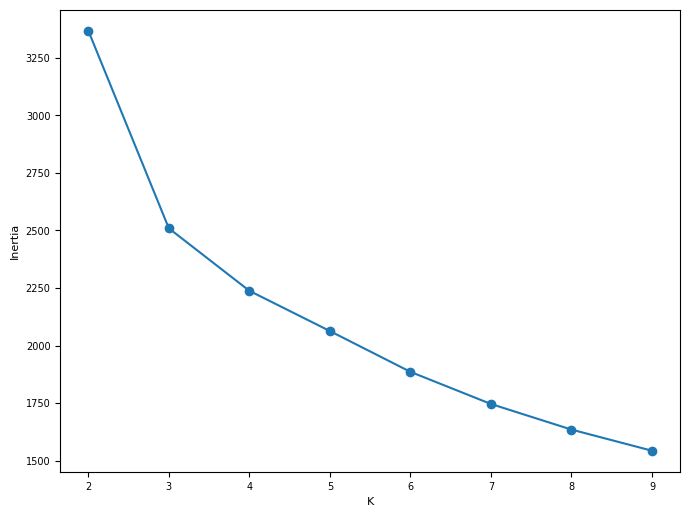

In [26]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.plot(range(2, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
inertia_values = list()
for k in range(2, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(off_rp_scaled).inertia_)
plot_elbow(8, 6, inertia_values)

### Silhouette Method

In [27]:
for i in range(2,10):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(off_rp_scaled).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
    +str(metrics.silhouette_score(off_rp_scaled,labels,metric="euclidean",sample_size=1000,random_state=200)))

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Silhouette score for k(clusters) = 2 is 0.27281049778249616
Silhouette score for k(clusters) = 3 is 0.2650178114498029
Silhouette score for k(clusters) = 4 is 0.2078195191876804


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Silhouette score for k(clusters) = 5 is 0.19462865691354148
Silhouette score for k(clusters) = 6 is 0.1884611128458524
Silhouette score for k(clusters) = 7 is 0.19328812754352784
Silhouette score for k(clusters) = 8 is 0.1828344364278789
Silhouette score for k(clusters) = 9 is 0.1858766651929553


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

### try k = 3, 4, 7

### KNN with PCA to decrease dimensionality

#### K = 3

In [28]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(off_rp_scaled)
pca_rp_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_rp_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=3)
kmeans_fit = kmeans_rp.fit(pca_rp_df)

# add predictions to dataframe
pca_rp_df["cluster"] = kmeans_rp.labels_
pca_rp_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,PC1,PC2,cluster
0,-1.225757,0.244296,1
1,-2.414577,-1.838592,1
2,-0.651387,1.887065,0
3,0.150579,-1.383047,1
4,-2.145501,-2.284411,1


In [29]:
# get variance explained by principal components
print(pca.explained_variance_ratio_.round(2)[:10])

[0.34 0.33]


In [30]:
# create final dataframe to visualize
off_rp_final_df = pd.concat([names_teams,pca_rp_df], axis=1)
off_rp_final_df.head()

,player,team,PC1,PC2,cluster
0,AJ Griffin,ATL,-1.225757,0.244296,1
1,Aaron Holiday,ATL,-2.414577,-1.838592,1
2,Aaron Nesmith,IND,-0.651387,1.887065,0
3,Aaron Wiggins,OKC,0.150579,-1.383047,1
4,Admiral Schofield,ORL,-2.145501,-2.284411,1


In [31]:
rp_kmeans_graph = alt.Chart(off_rp_final_df,title= 'NBA Role Player Offensive Roles Kmeans Clustering (K=3)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (34%)'),
         alt.Y('PC2',title = 'Principal Component 2 (33%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('player'),
                   alt.Tooltip('team')])

rp_kmeans_graph

alt.Chart(...)

In [32]:
# get variable contributions to principal components
weights = abs(pca.components_)
weights

array([[0.24364304, 0.1254684 , 0.17940824, 0.18694763, 0.24656296,
        0.29424912, 0.31965886, 0.05006929, 0.20510127, 0.20051119,
        0.17839257, 0.34174777, 0.22574709, 0.35184471, 0.21719495,
        0.35184471, 0.17053723],
       [0.31647606, 0.38605043, 0.32687257, 0.33757587, 0.26755123,
        0.22853387, 0.09962382, 0.24760804, 0.27832086, 0.35643677,
        0.01122107, 0.16679953, 0.11057839, 0.14370852, 0.16632943,
        0.14370852, 0.1459581 ]])

In [33]:
# create dataframe with weights and PCs
weights_df = pd.DataFrame(weights)
weights_df.columns = numeric_features
weights_df.index = ['PC1','PC2']
weights_df

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,apg,tov_pg,ppg,ast_tov_pg,fg_pct,efg_pct,fg2a_frequency,fg2_pct,fg3a_frequency,fg3_pct
PC1,0.243643,0.125468,0.179408,0.186948,0.246563,0.294249,0.319659,0.050069,0.205101,0.200511,0.178393,0.341748,0.225747,0.351845,0.217195,0.351845,0.170537
PC2,0.316476,0.386050,0.326873,0.337576,0.267551,0.228534,0.099624,0.247608,0.278321,0.356437,0.011221,0.166800,0.110578,0.143709,0.166329,0.143709,0.145958


#### K = 4

In [34]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(off_rp_scaled)
pca_rp_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_rp_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=4)
kmeans_fit = kmeans_rp.fit(pca_rp_df)

# add predictions to dataframe
pca_rp_df["cluster"] = kmeans_rp.labels_
pca_rp_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,PC1,PC2,cluster
0,-1.225757,0.244296,3
1,-2.414577,-1.838592,3
2,-0.651387,1.887065,1
3,0.150579,-1.383047,3
4,-2.145501,-2.284411,3


In [35]:
# create final dataframe to visualize
off_rp_final_df = pd.concat([names_teams,pca_rp_df], axis=1)
off_rp_final_df.head()

,player,team,PC1,PC2,cluster
0,AJ Griffin,ATL,-1.225757,0.244296,3
1,Aaron Holiday,ATL,-2.414577,-1.838592,3
2,Aaron Nesmith,IND,-0.651387,1.887065,1
3,Aaron Wiggins,OKC,0.150579,-1.383047,3
4,Admiral Schofield,ORL,-2.145501,-2.284411,3


In [36]:
rp_kmeans_graph = alt.Chart(off_rp_final_df,title= 'NBA Role Player Offensive Roles Kmeans Clustering (K=4)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (34%)'),
         alt.Y('PC2',title = 'Principal Component 2 (33%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('player'),
                   alt.Tooltip('team')])

rp_kmeans_graph

alt.Chart(...)

#### K = 7

In [37]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(off_rp_scaled)
pca_rp_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_rp_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=7)
kmeans_fit = kmeans_rp.fit(pca_rp_df)

# add predictions to dataframe
pca_rp_df["cluster"] = kmeans_rp.labels_
pca_rp_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,PC1,PC2,cluster
0,-1.225757,0.244296,6
1,-2.414577,-1.838592,1
2,-0.651387,1.887065,0
3,0.150579,-1.383047,1
4,-2.145501,-2.284411,1


In [38]:
# create final dataframe to visualize
off_rp_final_df = pd.concat([names_teams,pca_rp_df], axis=1)
off_rp_final_df.head()

,player,team,PC1,PC2,cluster
0,AJ Griffin,ATL,-1.225757,0.244296,6
1,Aaron Holiday,ATL,-2.414577,-1.838592,1
2,Aaron Nesmith,IND,-0.651387,1.887065,0
3,Aaron Wiggins,OKC,0.150579,-1.383047,1
4,Admiral Schofield,ORL,-2.145501,-2.284411,1


In [39]:
rp_kmeans_graph = alt.Chart(off_rp_final_df,title= 'NBA Role Player Offensive Roles Kmeans Clustering (K=7)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (34%)'),
         alt.Y('PC2',title = 'Principal Component 2 (33%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('player'),
                   alt.Tooltip('team')])

rp_kmeans_graph

alt.Chart(...)

In [40]:
## DEFENSIVE